# 0. Введение

В предыдущих тетрадках мы прошли все этапы пайплайна по обработке документов - от подготовки данных для обучения моделей до написания метрик. Нам остается только собрать все кусочки в один единый сервис. 

В этой тетрадке будем немного оптимизировать инференс, объединять детекцию, распознавание и извлечение сущностей и считать end-to-end метрики. План примерно такой: 

1. Инференс детектора текста;
2. Инференс распознавания текста; 
3. Инференс модели для линий; 
4. Объединение линий в параграфы; 
5. Объединение предыдущих четырех шагов в один метод по обработке изображения; 
6. Получить предсказание с помощью NER модели для распознанного текста
7. Подготовить данные и расчитать метрики
8. Собрать сервис на flask

Также на каждом этапе будем визуализировать результаты, чтобы убедиться, что мы ничего нигде не забыли. Поехали! 

Следующие несколько ячеек будут общими для всех ноутбуков.

* Эта ячейка настраивает отображение ipython widgets

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%matplotlib inline

* Подключаем Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* Указываем путь к папке с кодом: 

In [ ]:
repo_folder = '/content/drive/MyDrive/github/'

* Устанавливаем зависимости

In [ ]:
reqs_path = repo_folder + 'IntelligentDocumentProcessing/requirements.txt '
!pip3 install -r {reqs_path}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


* Подключаем WandB

In [ ]:
import wandb
wandb_key = open('/content/drive/MyDrive/ssh/wandbkey.txt').read().strip()
wandb.login(key=wandb_key)

wandb: Currently logged in as: nosenkoartyom1989. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

* Подключаем утилиты для этого ноутбука

In [ ]:
import sys
base_folder = repo_folder + 'IntelligentDocumentProcessing/Resources/e_Service_Deployment/'  # import utils
sys.path.append(base_folder)
sys.path.append(repo_folder + 'IntelligentDocumentProcessing/Resources/')  # from a_Text_Detection.utils import
sys.path.append(repo_folder)  # from IntelligentDocumentProcessing.Resources.a_Text_Detection.utils import

# 1: Перевод изображения в текст

## 1.1: Вход в пайплайн: изображение

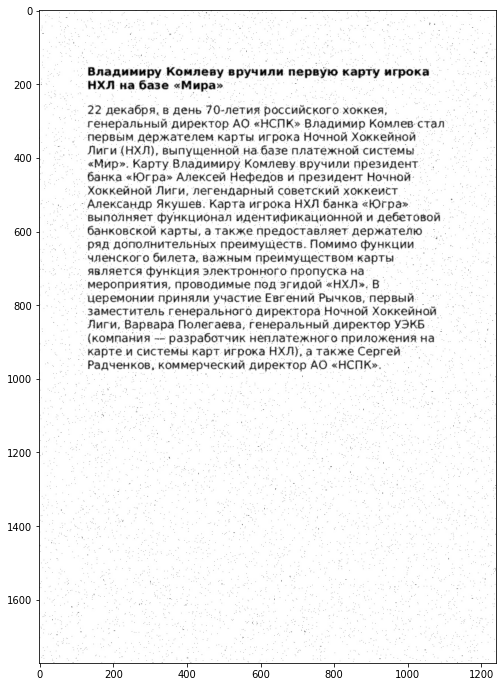

In [ ]:
import cv2
import matplotlib.pyplot as plt


image_fpath = base_folder+'ner_sample/821284f7-4c42-491e-b85d-9d37a2ce7a56.jpeg'

image = cv2.imread(image_fpath)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 12))
plt.imshow(image)
plt.show()

In [ ]:
from c_Layout_Analisys.utils import resize_aspect_ratio

device = 'cpu'
max_image_size = 2048

image_resized, _, _ = resize_aspect_ratio(image, square_size=max_image_size, interpolation=cv2.INTER_LINEAR)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

## 1.2: Детекция текста

Сначала на изображении найдем все локации, где есть текст и границы текста.

Для этого возьмем модель, которую мы обучили для этой цели, и применим ко входному изображению.

In [ ]:
import torch


model_fpath = '/content/drive/MyDrive/tmp/logs/sber-td-course/2022-11-03_v3/' + 'model.jit'
text_detection_model = torch.jit.load(model_fpath, map_location=torch.device(device))
text_detection_model.eval();

### Задача 1 (разминочная)

Метод для инференса детекции текста мы уже писали в первой тетрадке, поэтому необходимо просто вставить код из первой тетрадки сюда (только название должно быть `text_detection_inference`). 

#### Код

In [ ]:
from typing import Union, List

import albumentations as A
from albumentations import BasicTransform, Compose, OneOf
from albumentations.pytorch import ToTensorV2
import numpy as np
import torch.nn as nn

from a_Text_Detection.utils import Postprocessor, DrawMore

# КОД ДЛЯ СТУДЕНТА
# сюда необходимо вставить код для инференса модели из тетрадки по детекции
def text_detection_inference(
    model: nn.Module, 
    image: np.ndarray, 
    transform: Union[BasicTransform, Compose, OneOf],
    postprocessor: Postprocessor,
    device: str = 'cpu',
) -> List[np.ndarray]:
  w, h, _ =image.shape
  preproc_image = torch.unsqueeze(transform(image=image)['image'], 0)
  # предсказание модели (с помощью model)
  pred_image = model(preproc_image)
    # постпроцессинг предсказаний (с помощью postprocessor)
  contours = postprocessor(h, w, pred_image.detach().numpy(), return_polygon=False)
  get_4_dots=np.array(list(map(lambda x: Postprocessor.get_mini_boxes(x)[0], contours[0][0])))

  res=list(map(lambda x: np.array(x), get_4_dots))

  return res

size=2048
transform = A.Compose([

    A.Normalize(
        mean=[0, 0, 0],
        std=[1, 1, 1],
        max_pixel_value=255.,
        p=1.,
    ),
    ToTensorV2(p=1.)
])  # преобразование изображений

postprocessor = Postprocessor(
    unclip_ratio=1.5,
    binarization_threshold=0.3,
    confidence_threshold=0.55,
    min_area=1,
    max_number=1000
)

#### Проверка

In [ ]:
pred_bboxes = text_detection_inference(text_detection_model, image_resized, 
                                       transform, postprocessor, device)

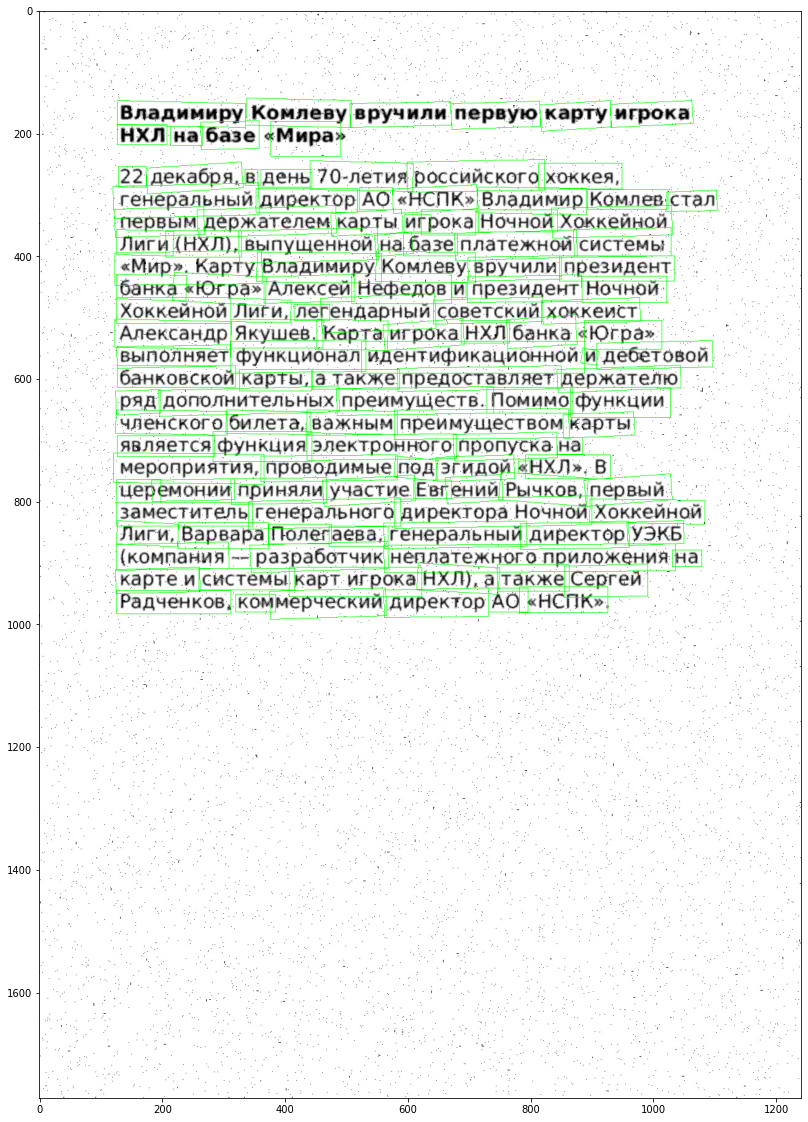

In [ ]:
# визуализация предсказаний
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image = cv2.resize(image, (2048, 2048))

plt.figure(figsize=(15,20))
plt.imshow(DrawMore.draw_contours(image, pred_bboxes, thickness=1))
plt.show()

Тут и далее мы будем сохранять результаты разных этапов обработки документа в папку `results`, поэтому необходимо для начала ее создать. 

In [ ]:
import os

# os.mkdir('results/')

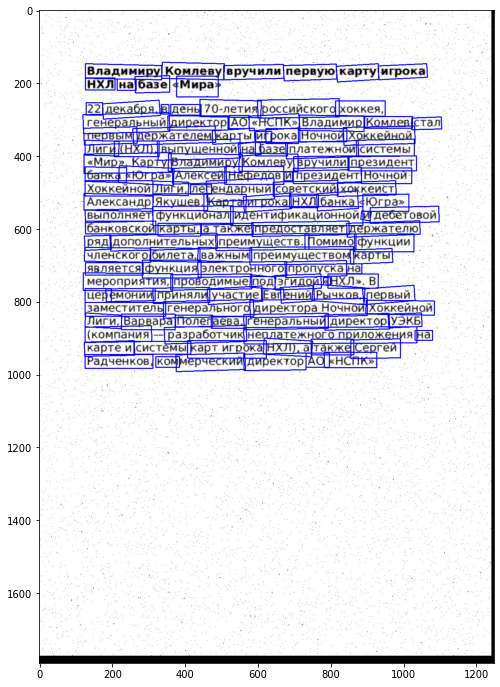

In [ ]:
countours_result = DrawMore.draw_contours(image_resized, pred_bboxes, thickness=2, color=(0, 0, 255))
out_image_fpath = 'results/contours.png'
cv2.imwrite(out_image_fpath, countours_result)

plt.figure(figsize=(15, 12))
plt.imshow(countours_result.astype('int'))
plt.show()

## 1.3: Распознавание символов текста

На данный момент мы имеем изображене и прямоугольники (bounding box'ы), которые предсказала модель. Но на вход в OCR мы подаем вырезанные небольшие изображения, поэтому их необходимо достать из исходного изображения: 

In [ ]:
from utils import prepare_crops

crops = prepare_crops(image_resized, pred_bboxes)

### Задача 2 (тоже разминочная)

Вырезанные изображения подготовлены, но помимо предобработки есть еще постобработка. Как мы помним, ее в случае OCR выполняет токенизатор, который будет переводить предсказания модели в символы. В следующей ячейке мы предлагаем вставить его реализацию из тетрадки по OCR:  

#### Код

In [ ]:
# КОД ДЛЯ СТУДЕНТА
# сюда необходимо вставить код токенайзера из тетрадки по распознаванию текста
import torch
from typing import List, Any, Tuple
from itertools import groupby

class TokenizerForCTC:
    def __init__(self, tokens: List[Any]):
        """
        Класс для преобразования текста в тензор для подачи в CTCLoss и преобразования из тензора в текст.

        Args:
            tokens: список токенов (символов) из алфавита
        """
        self.tokens = tokens
        self.blank_token = 0
        self.n_token = len(tokens) + 1
        self.char_idx = {}

        for i, char in enumerate(tokens):
          self.char_idx[char] = i + 1

    def encode(self, text: str) -> Tuple[torch.Tensor, int]:
        """
        Метод для преобразования текста в тензор для CTCLoss.

        Args:
            text: текст

        Returns:
            токенизированный текст в виде тензора, длина входного текста
        """
        results = []

        for char in text:
          results.append(self.char_idx[char])

        return torch.LongTensor(results).unsqueeze(1), len(results)

    def decode(self, preds: List[Any]) -> str:
        """
        Метод для перевода токенизированного текста в обычный текст.

        Args:
            preds: предсказания модели с одной строкой текста

        Returns:
            уверенность модели в виде вероятностей; строка с распознанным текстом
        """

        preds_unique = [g for g, _ in groupby(preds)]
        preds_ind = [ind for ind in preds_unique if ind > 0]

        list_chars = [self.tokens[ind - 1] for ind in preds_ind]
        text = ''.join(list_chars)
        return text

#### Проверка

In [ ]:
punct = " !\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~«»№"
digit = "0123456789"
cr = "ЁАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё"
latin = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
alphabet = punct + digit + cr + latin

tokenizer = TokenizerForCTC(list(alphabet))

На всякий случае продублируем проверку токенизатора, чтобы убедиться, что мы скопировали то, что надо: 

In [ ]:
correct_tensor = torch.tensor([132, 153, 149, 143, 152, 147, 164, 143, 156, 2]).unsqueeze(1)
encoded = tokenizer.encode('Tokenizer!')
assert len(encoded) == 2, 'Метод encode должен возвращать 2 элемента: тензор и длину последовательности.'
assert torch.equal(encoded[0], correct_tensor), 'Строка "Tokenizer!" закодирована неправильно.'
assert encoded[1] == 10, "Метод encode вернул неправильную длину последовательности."

decoded = tokenizer.decode([146, 146, 0, 143, 0, 150, 150, 0, 153])
assert decoded == 'helo', "Метод decode неправильно декодировал последовательность."

decoded = tokenizer.decode([146, 146, 0, 143, 0, 150, 150, 0, 150, 153])
assert decoded == 'hello', "Метод decode неправильно декодировал последовательность с повторяющимися символами. "

Далее нам понадобится модель OCR, которую вы обучили: 

In [ ]:
ocr_model_fpath = '/content/drive/MyDrive/tmp/logs/sber-tr-course/2022-11-13 /epoch=87_val_war=0.9473.ckpt' + 'model.jit'
ocr_model = torch.jit.load(ocr_model_fpath, map_location=torch.device(device))
ocr_model.eval();

### Задача 3: Батчевание инференса распознавания текста

У вас уже есть код для инференса модели для одного изображения, но делать инференс по одному изображению вычислительно невыгодно, поэтому теперь для оптимизации необходимо реализовать инференс с изменяемым размером батча. Итак, алгоритм:
1. Разбить входящие изображения с помощью метода `batchings` (это функция-генератор, которая принимает на вход список объектов и размер батча, а возвращает с помощью `yield` батчи по очереди);
3. Каждую картинку в батче преобразовать с помощью `resize_by_height`;
4. Вычислить максимальную ширину изображения в батче; 
5. Добить все изображения в батче до одной ширины значениями `pad_value`. Можно использовать метод `torch.nn.functional.pad` или `cv2.copyMakeBorder`;
6. Привести все изображения к тензорам и объединить в один тензор через `torch.stack`;
7. Далее идет почти обычный инференс, только возвращать метод будет не строку, а список строк. 

#### Код

In [ ]:
import torch.nn.functional as F

from utils import batchings
from b_Optical_Character_Recognition.utils import resize_by_height

# КОД ДЛЯ СТУДЕНТА
def ocr_inference(
    model: nn.Module, 
    image: np.ndarray, 
    transform: Union[BasicTransform, Compose, OneOf],
    tokenizer: TokenizerForCTC, 
    device: str = 'cpu',
    batch_size: int = 1,
    target_height: int = 32,
    pad_value: int = 0
) -> List[str]:
   labels = []
   model.to(device)
   for batch_images in batchings(image, batch_size=batch_size):
        # делаем resize для всех картинок в батчке
        batch_images = [resize_by_height(image, target_height=target_height) for image in batch_images]
        # находим максимальную ширину картинки в батчке
        target_width = max([image.shape[1] for image in batch_images])
        # делаем трансформацию картинок
        tensor_images = [transform(image=image)['image'] for image in batch_images]
        
        # делаем pad для всех картинок
        padded_images = []
        for image in tensor_images:
            c, h, w = image.shape
            image = F.pad(image, (0, target_width-w), value=pad_value)
            padded_images.append(image)
        batch_tensor = torch.stack(padded_images, dim=0).to(device)
        
        # делаем сам inference
        with torch.no_grad():
              current_batch_size = batch_tensor.shape[0]
              preds = model(batch_tensor)
              preds_size = torch.IntTensor([preds.size(0)] * current_batch_size)
              preds = preds.log_softmax(dim=2)
              _, preds = preds.max(2)
              preds = preds.transpose(1, 0).detach().cpu().numpy()
              labels.extend([tokenizer.decode(p) for p in preds])
              
   return labels

post_transform = A.Compose([
    A.Normalize(
        mean=[0., 0., 0.],
        std=[1., 1., 1.],
        max_pixel_value=255.,
        p=1.,
    ),
    ToTensorV2(p=1.)
])
transform = post_transform

In [ ]:
labels = ocr_inference(ocr_model, 
                       crops, 
                       transform, tokenizer, device, batch_size=8)

#### Проверка

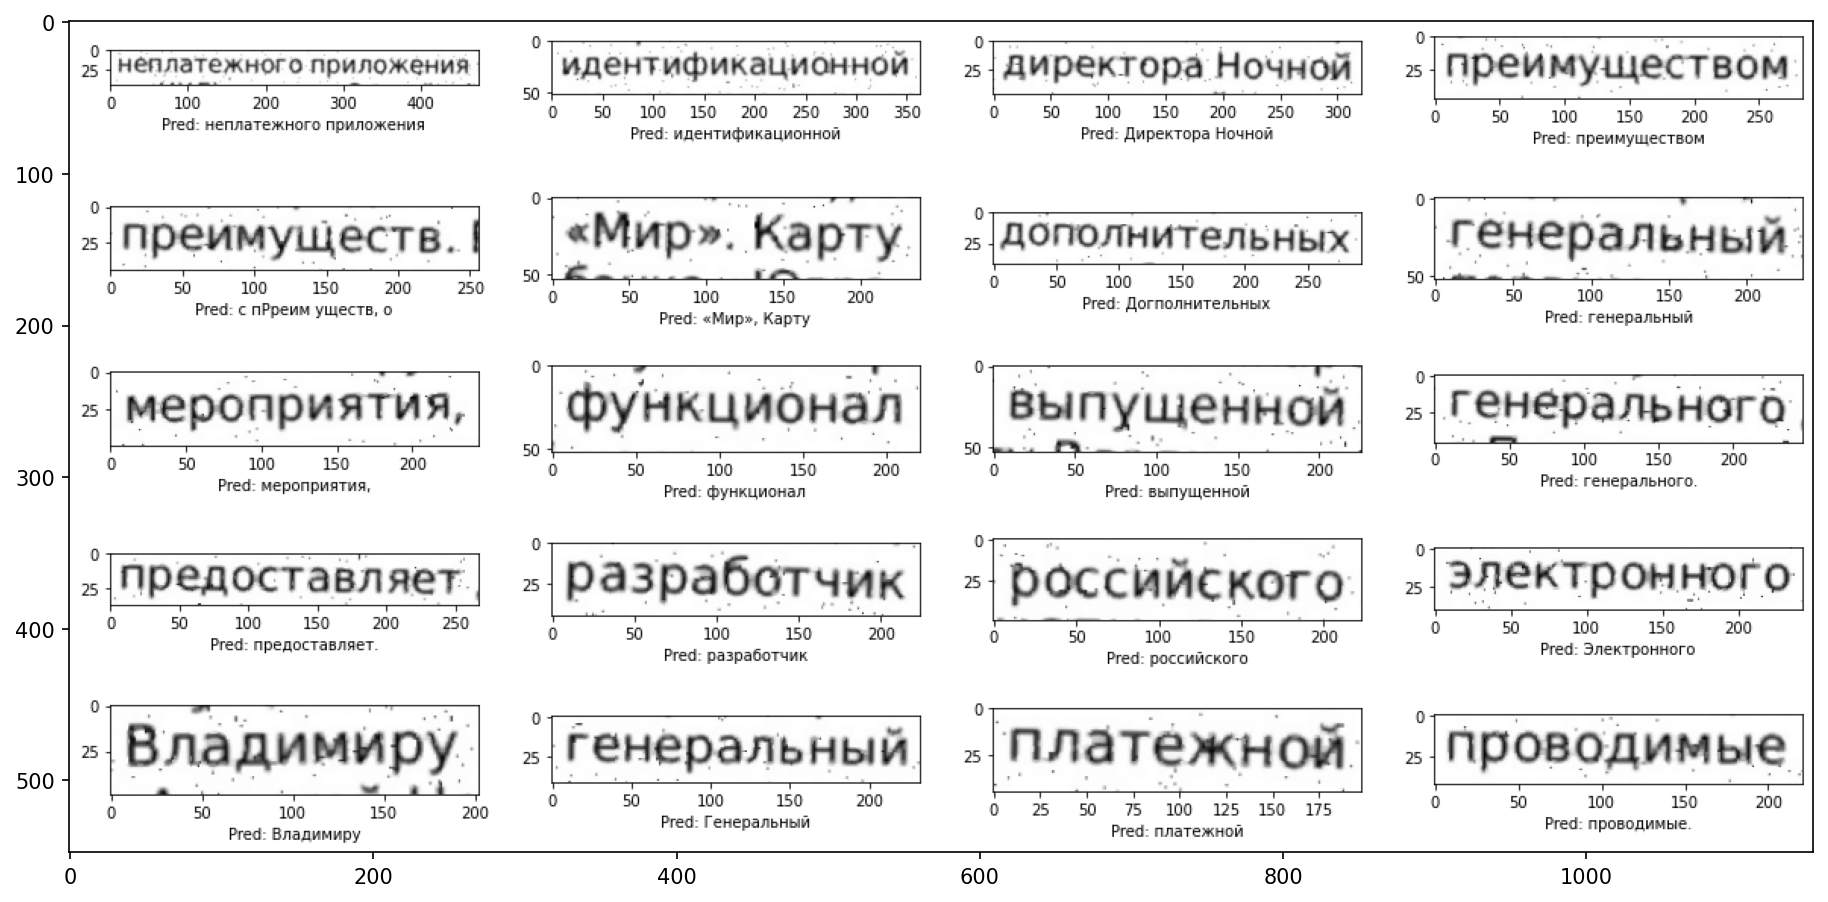

In [ ]:
from b_Optical_Character_Recognition.utils import draw_predictions

out_image_fpath = 'results/ocr.png'
_ = draw_predictions(
    crops, 
    predicted_texts=labels, 
    path_to_save_image=out_image_fpath,
    max_elements_to_draw=16
)

image = cv2.imread(out_image_fpath)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 15), dpi=150)
plt.imshow(image)
plt.show()

In [ ]:
from c_Layout_Analisys.utils import Word

words = [Word(bbox, label) for bbox, label in zip(pred_bboxes, labels) if len(label) > 0]

## 1.4: Сборка текста в строки и параграфы

Загружаем модель для предсказания строк, которая нам уже знакома. Напоминаем, что это модель с архитектурой DB (очень похожая на модель детекции текста), которая выдает нам линии, а линии необходимо собрать в параграфы. 

In [ ]:
line_model_path = '/content/drive/MyDrive/data/la_data/la.jit'
line_model = torch.jit.load(line_model_path, map_location=torch.device(device))
line_model.eval();

### Задача 4:

Возьмем код из тетрадки по layout analysis с инференсом модели по предсказанию линий: 

#### Код

In [ ]:
from c_Layout_Analisys.utils import Line

# необходимо вставить сюда инференс из тетрадки по layout
# КОД ДЛЯ СТУДЕНТА
def line_detector_inference(
    model: nn.Module, 
    image: np.ndarray, 
    transform: Union[BasicTransform, Compose, OneOf],
    postprocessor: Postprocessor,
    device: str = 'cpu',
) -> List[Line]:
    w, h, _ =image.shape
    # model.to(device)
    # подготовка изображения (c помощью transform)
    preproc_image = torch.unsqueeze(transform(image=image)['image'], 0)
    # предсказание модели (с помощью model)
    pred_image = line_model(preproc_image)
    print(preproc_image.shape)
    # постпроцессинг предсказаний (с помощью postprocessor)
    contours = postprocessor(h, w, 
                             pred_image[0].detach().numpy(), 
                             return_polygon=False)
    bboxs = np.array(list(map(lambda x: Postprocessor.get_mini_boxes(x)[0], contours[0][0])))    
    
    # создание списка объектов типа Line 
    lines = []
    for bbox_i, label_i in zip(bboxs, contours[1][0]):
      line = Line()
      line.bbox = bbox_i
      line.normalized_bbox = line.bbox / np.array([w, h])
      line.normalized_bbox = np.clip(line.normalized_bbox, 0, 1)                              
      
      line.label = label_i
      lines.append(line)

    return lines

size=2048
transform = A.Compose([

    A.Normalize(
        mean=[0, 0, 0],
        std=[1, 1, 1],
        max_pixel_value=255.,
        p=1.,
    ),
    ToTensorV2(p=1.)
])  # преобразование изображений

postprocessor = Postprocessor(
    unclip_ratio=1.5,
    binarization_threshold=0.3,
    confidence_threshold=0.55,
    min_area=1,
    max_number=1000
)

#### Проверка

Проверим детектирование строк текста: 

In [ ]:
lines = line_detector_inference(line_model, image_resized, 
                                transform, postprocessor, device)

torch.Size([1, 3, 1792, 1248])


In [ ]:
from utils import group_words_by_lines_or_lines_by_paragraphs 
from c_Layout_Analisys.utils import sort_boxes

# сгруппируем слова в линии по IOU
h, w, _ = image_resized.shape
lines = group_words_by_lines_or_lines_by_paragraphs(words, lines, w, h)
lines = [line for line in lines if len(line.items) > 0]
for line in lines:
    line.items = sort_boxes(line.items, sorting_type = 'left2right')  # сортировка слева направо
    line.label = ' '.join([word.label.strip() for word in line.items])

/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/e_Service_Deployment/utils.py:124: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(inner_element_polygons)


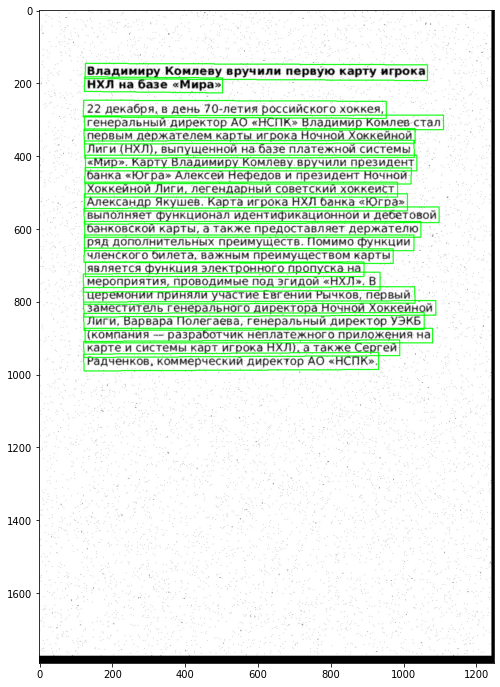

In [ ]:
lines_result = DrawMore.draw_contours(image_resized, 
                                      [line.bbox for line in lines], thickness=2)
out_image_fpath = 'results/lines.png'
cv2.imwrite(out_image_fpath, lines_result)

plt.figure(figsize=(15, 12))
plt.imshow(lines_result.astype('int'))
plt.show()

Загрузим объект класса `ParagraphFinder` и проверим сборку параграфов текста:

In [ ]:
import math

import dill
from sklearn.cluster import DBSCAN

from c_Layout_Analisys.utils import sort_boxes_top2down_wrt_left2right_order, sort_boxes, fit_bbox, Paragraph

path_to_pf = '/content/drive/MyDrive/github/models/paragraph_finder.pkl'
with open(path_to_pf, 'rb') as r:
    paragraph_finder = dill.load(r)

### Добавим сюда поиск параграфов


In [ ]:
import math

from sklearn.cluster import DBSCAN

from c_Layout_Analisys.utils import sort_boxes_top2down_wrt_left2right_order, sort_boxes, fit_bbox, Paragraph

# КОД ДЛЯ СТУДЕНТА
class ParagraphFinder:
    def __init__(
        self, 
        angle_threshold: int = 10, 
        overlapping_threshold: float = 0.3, 
        max_distance: int = 1,
        cluster_eps: float = 0.5
    ):
        self.angle_threshold = angle_threshold
        self.overlapping_threshold = overlapping_threshold
        self.max_distance = max_distance
        self.cluster_eps = cluster_eps
    
    @staticmethod
    def _distance(line1: Line, line2: Line) -> float:
        return ((np.mean(line1.normalized_bbox[:, 1]) - np.mean(line2.normalized_bbox[:, 1]))**2)**0.5

    @staticmethod
    def _length(line: Line) -> float:
        return np.sum((line.normalized_bbox[0, :] - line.normalized_bbox[1, :])**2)**0.5 

    def _overlapping(self, line1: Line, line2: Line) -> float:
        overlapping =(min(line1.normalized_bbox[1, 0], line2.normalized_bbox[1, 0]) 
                    - max(line1.normalized_bbox[0, 0], line2.normalized_bbox[0, 0])) / self._length(line1)
        if overlapping < 0:
          return 0
        return overlapping
    
    @staticmethod
    def _dot(self, line1: Line, line2: Line):
        return np.sum(np.dot(line1.normalized_bbox[:2], line2.normalized_bbox[:2]))

    @staticmethod
    def _angle(line1: Line, line2: Line) -> float:
        x1, y1 = line1.normalized_bbox[1,] - line1.normalized_bbox[0,]
        x2, y2 = line2.normalized_bbox[1,] - line2.normalized_bbox[0,]

        return math.degrees(math.atan(y2/x2)-math.atan(y1/x1))


    def paragraph_distance(self, line1: np.ndarray, line2: np.ndarray) -> float:
        line1 = Line(normalized_bbox=line1.reshape(4, 2))
        line2 = Line(normalized_bbox=line2.reshape(4, 2))

        if abs(self._angle(line1, line2)) > self.angle_threshold:
            return self.max_distance

        if self._overlapping(line1, line2) < self.overlapping_threshold:
            return self.max_distance

        return self._distance(line1, line2)
    
    @staticmethod
    def prepare_lines(lines: List[Line]) -> np.ndarray:
        return np.array([line.normalized_bbox.reshape(-1) for line in lines])
    
    def fit_cluster(self, lines: List[Line]) -> DBSCAN: 
        prepared_lines = self.prepare_lines(lines)
        cluster = DBSCAN(metric=self.paragraph_distance, eps=self.cluster_eps)
        cluster.fit(prepared_lines)
        return cluster
    
    @staticmethod
    def sort_paragraphs(paragraphs):
        for par in paragraphs:
            par.items = sort_boxes(par.items, sorting_type = 'top2down')  # сортировка сверху вниз
        paragraphs = sort_boxes_top2down_wrt_left2right_order(paragraphs)  # сортировка в порядке чтения
        return paragraphs
    
    def find_paragraphs(self, lines: List[Line]) -> List[Paragraph]:
        cluster = self.fit_cluster(lines)
        
        paragraphs = []
        for label in set(cluster.labels_):
            line_indexes = np.argwhere(cluster.labels_ == label)
            par_lines = [lines[idx[0]] for idx in line_indexes]
            bbox = fit_bbox(np.array([lines[idx[0]].bbox for idx in line_indexes]))
            par = Paragraph(items=par_lines, bbox=bbox)
            paragraphs.append(par)
        paragraphs = self.sort_paragraphs(paragraphs)
        return paragraphs
paragraph_finder = ParagraphFinder(overlapping_threshold=0.05, 
                                   cluster_eps=0.3)

In [ ]:
paragraphs = paragraph_finder.find_paragraphs(lines)

In [ ]:
for para in paragraphs:
    para.label = ' '.join([line.label.strip() for line in para.items])

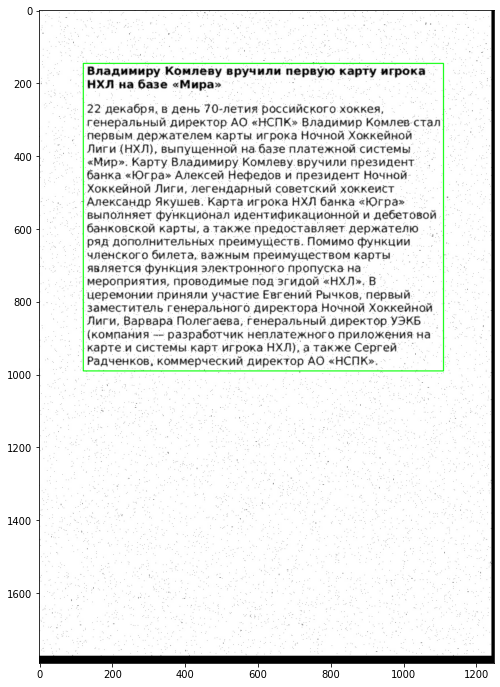

In [ ]:
para_result = DrawMore.draw_contours(image_resized, [para.bbox for para in paragraphs], thickness=2)
out_image_fpath = 'results/paragraphs.png'
cv2.imwrite(out_image_fpath, para_result)

plt.figure(figsize=(15, 12))
plt.imshow(para_result.astype('int'))
plt.show()

## 1.5: Сборка end-to-end OCR

Мы проверили, что каждый отдельный модуль приложения работает. Теперь сделаем функцию, которая на вход будет принимать документ, а на выходе будет выдавать текст.

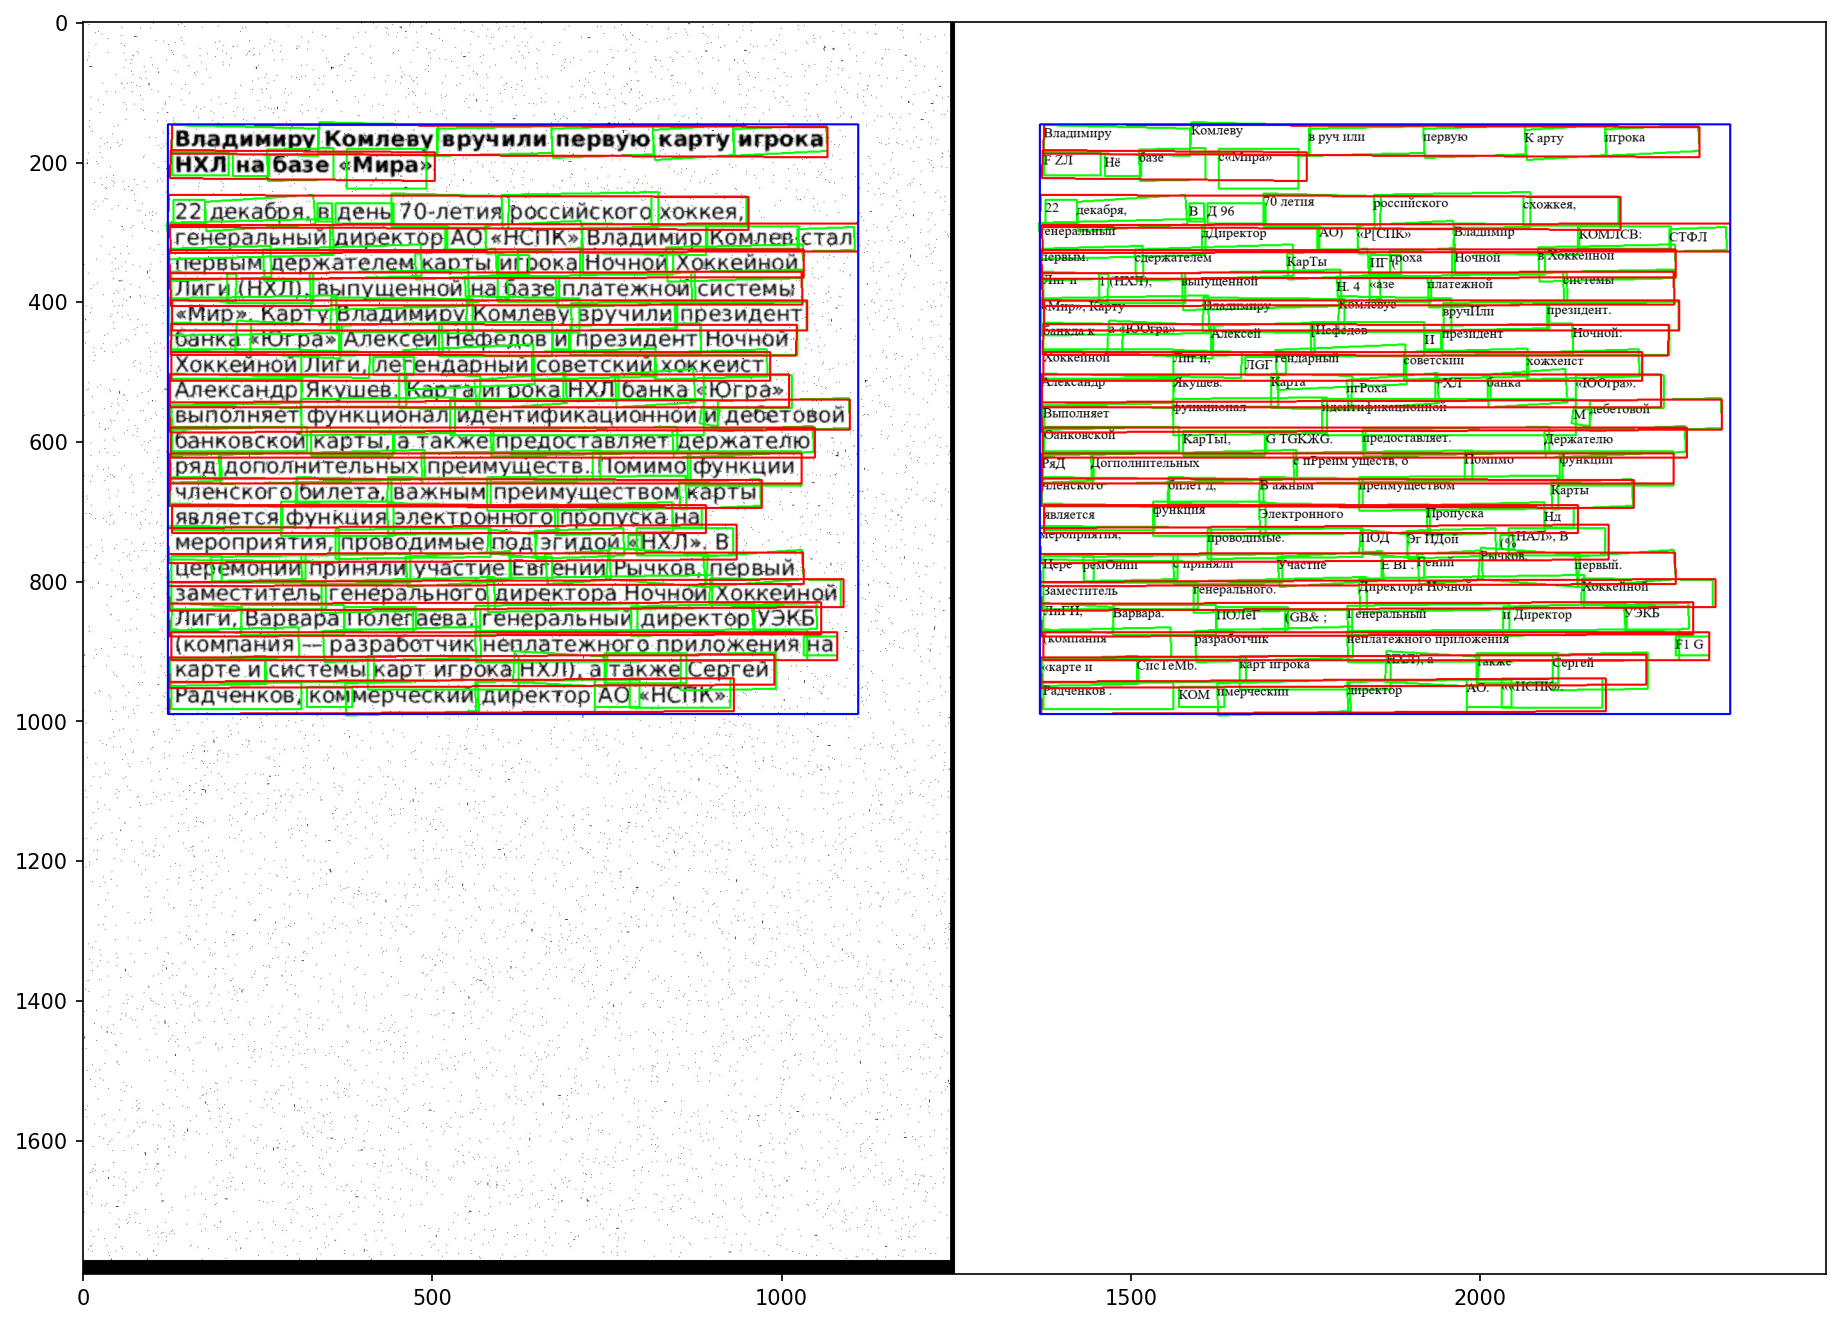

In [ ]:
from utils import visualize_e2e

out_image_fpath = 'results/end2end.png'
font_path = repo_folder + 'IntelligentDocumentProcessing/Resources/b_Optical_Character_Recognition/resources/fonts/times.ttf'
_ = visualize_e2e(image_resized, paragraphs, font_path=font_path,
                  fontsize=20, font_color=(0, 0, 0), thickness=2, show_words=True, 
                  show_lines=True, show_groups=True, path_to_save_image=out_image_fpath)

image = cv2.imread(out_image_fpath)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 12), dpi=150)
plt.imshow(image)
plt.show()

### Задача 4. Полный пайплайн распознавания документа

У вас есть все готовые методы для распознавания - осталось только собрать их в один метод. Параметры метода, кроме `image` и `device`, вы определяете сами, а на выходе должен получиться список DTO типа `Paragraph`. Что должно быть внутри метода: 

1. Инференс модели детектора текста - метод `text_detection_inference` в помощь;
1. Вызов метода `prepare_crops`, который вырезает из изображения прямоугольники с текстом; 
1. Инференс модели распознавания текста - метод `ocr_inference`;
1. Инференс модели, которая находит линии - метод `line_detector_inference`;
1. Объединение слов и линий с помощью метода `group_words_by_lines_or_lines_by_paragraphs`;
1. Сортировка слов в линиях;
1. Объединение линий в параграфы с помощью `paragraph_finder`.  


#### Код

In [ ]:
# КОД ДЛЯ СТУДЕНТА
def recognition_pipeline(
    image: np.ndarray,
    device: str,
    **kwargs
) -> List[Paragraph]:

    # параметры на входе
    detection_model = kwargs['detection_model']                 # модель детекции
    detection_transform = kwargs['detection_transform']         # трансформации картинки
    detection_postprocessor = kwargs['detection_postprocessor'] # постпроцессор детекиции
    line_model = kwargs['line_model']                           # модель для объединения линий
    line_transform = kwargs['line_transform']                   # модель для объединения линий
    line_postprocessor = kwargs['line_postprocessor']           # построцессор
    paragraph_model = kwargs['paragraph_model']                 # объед в параграфы
    ocr_model = kwargs['ocr_model']                             # OCR-модель 
    ocr_transform = kwargs['ocr_transform']                     # трансформации для модели OCR
    ocr_tokenizer = kwargs['ocr_tokenizer']                     # OCR токенайзер
    ocr_batch_size = kwargs['ocr_batch_size']                   # размер батча для OCR

    # делаем детекцию
    pred_bboxes = text_detection_inference(detection_model, image, 
                                           detection_transform, detection_postprocessor, device)
    crops = prepare_crops(image, pred_bboxes)
    # делаем OCR
    labels = ocr_inference(ocr_model, 
                           crops, 
                           ocr_transform, ocr_tokenizer, device, batch_size=ocr_batch_size)
    # делаем line detection
    lines = line_detector_inference(line_model, image, 
                                    line_transform, line_postprocessor, device)
    h, w, _ = image.shape
    
    # группируем слова в линии или параграфы
    words = [Word(bbox, label) for bbox, label in zip(pred_bboxes, labels) if len(label) > 0]
    lines = group_words_by_lines_or_lines_by_paragraphs(words, lines, w, h)
    lines = [line for line in lines if len(line.items) > 0]
    for line in lines:
        line.items = sort_boxes(line.items, sorting_type = 'left2right')  # сортировка слева направо
        line.label = ' '.join([word.label.strip() for word in line.items])

    paragraphs = paragraph_model.find_paragraphs(lines)
    for para in paragraphs:
        para.label = ' '.join([line.label.strip() for line in para.items])
    return paragraphs

#### Проверка

In [ ]:
full_pipeline_paragraphs = recognition_pipeline(
    image=image_resized, 
    device=device,
    detection_model=text_detection_model,
    detection_transform=transform,
    detection_postprocessor=postprocessor,
    line_model=line_model,
    line_transform=transform,
    line_postprocessor=postprocessor,
    paragraph_model=paragraph_finder,
    ocr_model=ocr_model,
    ocr_transform=transform,
    ocr_tokenizer=tokenizer,
    ocr_batch_size=8
)

for para in full_pipeline_paragraphs:
    for i, line in enumerate(para.items):
        print(i, line.label)

torch.Size([1, 3, 1792, 1248])
0 Владимиру Комлеву в руч или первую К арту игрока
1 F ZЛ Нё базе с«Мира»
2 22 декабря, В Д 96 70 летия российского схожкея,
3 генеральный дДиректор АО) «Р[СПК» Владимир КОМЛСВ: СТФЛ
4 первым. сдержателем КарТы ИГ ( гроха Ночной в Хоккейной
5 Лиг и 1 (НХЛ), выпущенной Н. 4 «азе платежной системы
6 «Мир», Карту Владимиру Комлевус вручИли президент.
7 банкда к а «ЮОгра» Алексей [Нефедов И президент Ночной:
8 Хоккейной Лиг и, ЛGГ гендарный советский хожхеист
9 Александр Якушев. Карта игРоха +ХЛ банка «ЮОгра».
10 Выполняет функционал идентификационной М дебетовой
11 Оанковской KaрТыl, G TGKЖG. предоставляет. Держателю
12 РяД Догполнительных с пРреим уществ, о Помимо функции
13 членского билет д, В ажным преимуществом Карты
14 является функция Электронного Пропуска Нд
15 мероприятия, проводимые. ПОД Эг ИДой (% +НАЛ», В
16 Цере ремОнии с приняли Участие E BГ. Гений Рычков, первый.
17 Заместитель генерального. Директора Ночной Хоккейной
18 ЛиГИ, Варвара. ПОЛёГ (

/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/e_Service_Deployment/utils.py:124: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(inner_element_polygons)


В следующей ячейке будут сравниваться параграфы, которые мы получили из метода `recognition_pipeline`, и те, которые мы получили, прогоняя модели по отдельности (в переменной `paragraphs`). 

In [ ]:
para_msg = 'Количество параграфов после Е2Е не совпадает с количеством параграфов в paragraphs.'
assert len(paragraphs) == len(full_pipeline_paragraphs), para_msg
for para, fp_para in zip(paragraphs, full_pipeline_paragraphs):
    label_msg = 'Текст каждого параграфа должен совпадать.'
    assert para.label == fp_para.label, label_msg
    bbox_msg = 'Bounding box каждого параграфа должен совпадать.'
    assert np.array_equal(para.bbox, fp_para.bbox), bbox_msg
    len_msg = 'Количество линий в каждом параграфе должно совпадать.'
    assert len(para.items) == len(fp_para.items), len_msg
    for line, fp_line in zip(para.items, fp_para.items):
        label_msg = 'Текст каждой линии должен совпадать.'
        assert line.label == fp_line.label, label_msg
        bbox_msg = 'Bounding box каждой линии должен совпадать.'
        assert np.array_equal(line.bbox, fp_line.bbox), bbox_msg
        for word, fp_word in zip(line.items, fp_line.items):
            label_msg = 'Текст каждого слова должен совпадать.'
            assert word.label == fp_word.label, label_msg
            bbox_msg = 'Bounding box каждого слова должен совпадать.'
            assert np.array_equal(word.bbox, fp_word.bbox), bbox_msg

### Задача 5. OCR на строках

Вы обучали OCR не просто на отдельных словах или парах слов, а на целых строках до 10-11 слов. Давайте теперь посмотрим, как эта модель себя поведет, если использовать ее на целых строках.

Вам необходимо написать метод, который будет аналогичным методу `recognition_pipeline`, но только OCR будет применяться к задетектированным строкам. 

Также параметры данного метода вы выбираете самостоятельно (кроме `image` и `device`). 

#### Код

In [ ]:
# КОД ДЛЯ СТУДЕНТА
def line_recognition_pipeline(
    image: np.ndarray,
    device: str,
    **kwargs
) -> List[Paragraph]:
    
    line_model = kwargs['line_model']    
    line_transform = kwargs['line_transform']    
    line_postprocessor = kwargs['line_postprocessor']
    paragraph_model = kwargs['paragraph_model']
    ocr_model = kwargs['ocr_model']
    ocr_transform = kwargs['ocr_transform']    
    ocr_tokenizer = kwargs['ocr_tokenizer']
    ocr_batch_size = kwargs['ocr_batch_size']

    lines = line_detector_inference(line_model, 
                                    image, 
                                    line_transform, line_postprocessor, device)
    h, w, _ = image.shape
    # words = [Word(bbox, label) for bbox, label in zip(pred_bboxes, labels) if len(label) > 0]
    lines = group_words_by_lines_or_lines_by_paragraphs(words, lines, w, h)
    lines = [line for line in lines if len(line.items) > 0]
    for line in lines:
        line.items = sort_boxes(line.items, sorting_type = 'left2right')  # сортировка слева направо
        line.label = ' '.join([word.label.strip() for word in line.items])

    paragraphs = paragraph_model.find_paragraphs(lines)
    for para in paragraphs:
        para.label = ' '.join([line.label.strip() for line in para.items])
    return paragraphs

#### Проверка

In [ ]:
line_pipeline_paragraphs = line_recognition_pipeline(
    image=image_resized,
    line_model=line_model,
    line_transform=transform,
    line_postprocessor=postprocessor,
    paragraph_model=paragraph_finder,
    ocr_model=ocr_model,
    ocr_transform=transform,
    ocr_tokenizer=tokenizer,
    ocr_batch_size=8,
    device=device
)

for para in line_pipeline_paragraphs:
    for i, line in enumerate(para.items):
        print(i, line.label)

torch.Size([1, 3, 1792, 1248])
0 Владимиру Комлеву в руч или первую К арту игрока
1 F ZЛ Нё базе с«Мира»
2 22 декабря, В Д 96 70 летия российского схожкея,
3 генеральный дДиректор АО) «Р[СПК» Владимир КОМЛСВ: СТФЛ
4 первым. сдержателем КарТы ИГ ( гроха Ночной в Хоккейной
5 Лиг и 1 (НХЛ), выпущенной Н. 4 «азе платежной системы
6 «Мир», Карту Владимиру Комлевус вручИли президент.
7 банкда к а «ЮОгра» Алексей [Нефедов И президент Ночной:
8 Хоккейной Лиг и, ЛGГ гендарный советский хожхеист
9 Александр Якушев. Карта игРоха +ХЛ банка «ЮОгра».
10 Выполняет функционал идентификационной М дебетовой
11 Оанковской KaрТыl, G TGKЖG. предоставляет. Держателю
12 РяД Догполнительных с пРреим уществ, о Помимо функции
13 членского билет д, В ажным преимуществом Карты
14 является функция Электронного Пропуска Нд
15 мероприятия, проводимые. ПОД Эг ИДой (% +НАЛ», В
16 Цере ремОнии с приняли Участие E BГ. Гений Рычков, первый.
17 Заместитель генерального. Директора Ночной Хоккейной
18 ЛиГИ, Варвара. ПОЛёГ (

/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/e_Service_Deployment/utils.py:124: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(inner_element_polygons)


## 1.6. Применение модели NER для полученного текста

Теперь наша задача запустить полный пайплайн, где на входе мы отправляем картинку, а на выходе имеет сущности с их координатами.

Поэтому выделим два основных компнонета: 

* `OCR Pipeline`
* `NER Model`


C `OCR` нам теперь все понятно, соберем только все вместе и получим текст с которым будем работать в `NER` на примере одной картинки. 


In [ ]:
device = 'cuda:0'
max_image_size = 2048

# image_fpath = './team_idp/ocr_service/ner_sample/821284f7-4c42-491e-b85d-9d37a2ce7a56.jpeg'
image_fpath = base_folder+'ner_sample/821284f7-4c42-491e-b85d-9d37a2ce7a56.jpeg'


image = cv2.imread(image_fpath)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_resized, _, _ = resize_aspect_ratio(image, square_size=max_image_size, interpolation=cv2.INTER_LINEAR)

In [ ]:
line_pipeline_paragraphs = line_recognition_pipeline(
    image=image_resized,
    line_model=line_model,
    line_transform=transform,
    line_postprocessor=postprocessor,
    paragraph_model=paragraph_finder,
    ocr_model=ocr_model,
    ocr_transform=transform,
    ocr_tokenizer=tokenizer,
    ocr_batch_size=8,
    device='cpu'
)

rec_text = " ".join([line.label for para in line_pipeline_paragraphs for i, line in enumerate(para.items)])

torch.Size([1, 3, 1792, 1248])


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/e_Service_Deployment/utils.py:124: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(inner_element_polygons)


#### Визуализируем исходный документ и заодно посмотрим на текст из OCR Pipeline


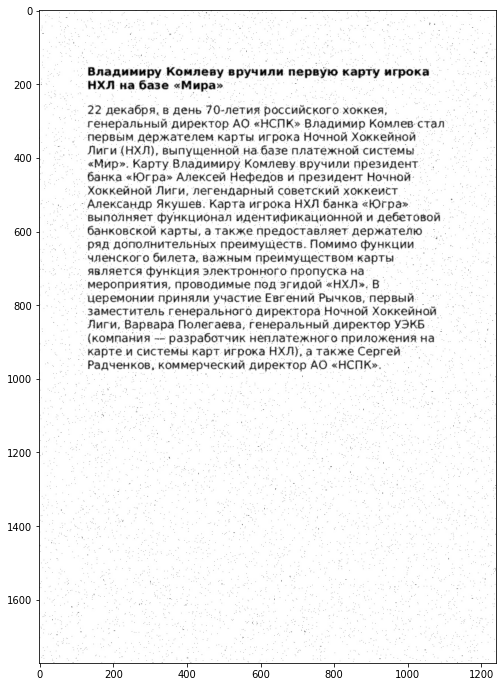


Recognized text: 

Владимиру Комлеву в руч или первую К арту игрока F ZЛ Нё базе с«Мира» 22 декабря, В Д 96 70 летия российского схожкея, генеральный дДиректор АО) «Р[СПК» Владимир КОМЛСВ: СТФЛ первым. сдержателем КарТы ИГ ( гроха Ночной в Хоккейной Лиг и 1 (НХЛ), выпущенной Н. 4 «азе платежной системы «Мир», Карту Владимиру Комлевус вручИли президент. банкда к а «ЮОгра» Алексей [Нефедов И президент Ночной: Хоккейной Лиг и, ЛGГ гендарный советский хожхеист Александр Якушев. Карта игРоха +ХЛ банка «ЮОгра». Выполняет функционал идентификационной М дебетовой Оанковской KaрТыl, G TGKЖG. предоставляет. Держателю РяД Догполнительных с пРреим уществ, о Помимо функции членского билет д, В ажным преимуществом Карты является функция Электронного Пропуска Нд мероприятия, проводимые. ПОД Эг ИДой (% +НАЛ», В Цере ремОнии с приняли Участие E BГ. Гений Рычков, первый. Заместитель генерального. Директора Ночной Хоккейной ЛиГИ, Варвара. ПОЛёГ (GB& ; Генеральный и Директор УЭКБ (компания разработчик не

In [ ]:
image = cv2.imread(image_fpath)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 12))
plt.imshow(image)
plt.show()
print()
print("Recognized text: ")
print()
print(rec_text)

Как и говорилось раньнее к этому занятию у вас должна быть обучена `NER` модель на основе датасета `RuRed`. Загружаем лучший ваш чекпоинт, сконвертированный в `jit`. 


In [ ]:
rec_text = """
  Владимиру Комлеву вручили первую карту игрока
  В НХЛ на базе «Мира» .
  22 декабря, в день 70летия российского хоккея, был праздник.
  В генеральный директор АО «КПК» Владимир Комлев стал чеспионом.
  В первым держателем карты игрока Ночной Хоккейнойв Лиги (НХЛ), выпущенной на базе платежной системы
  «Мир», Карту Владимиру Комлеву вручили президент Обанка «Югра» Алексей Нефедов и президент Ночной. 
  """

In [ ]:
model = torch.jit.load("/content/drive/MyDrive/tmp/logs/ner/ner_runne.jit")

In [ ]:
from ner_model import inference_ner_model
from ipymarkup import show_span_line_markup

# Готовим примеры для подачи в датасет, оставляем формат, который был использован при обучении, но без сущностей
samples = [((0, len(rec_text), rec_text),[])]

result = inference_ner_model(samples, model, "cpu", batch_size = 4, num_workers = 4)

for sample_predictions in result:
    show_span_line_markup(*sample_predictions)
    print()

### Итого:
  - Мы собрали рабочий пайплайн, котрый умеет превращать картинку в текст и извлекать из текста некоторый набор сущностей.

  - Мы МОЛОДЦЫ!

  - Однако есть еще работа, которую мы должны выполнить. О ней речь пойдет в следующей главе этой тетрадки.

# 2. Тестирование итогового пайплайна структурирования информации



##  2.1. Подготовка данных для тестирования
И снова нам нужно готовить данные, а именно сопоставить:
- С точки зрения распознавания
  - Изображение
  - Предсказанный текстовый слой для изображения
- С точки зрения извлечения:
  - Исходный текст новости
  - Разметку для исходного текста 
  - Предсказания `NER` модели

Все это нам нужно для того, что замерить качество структурирования информации полным.

In [ ]:
from glob import glob

def map_images_and_annotation(annotation_path: str, images_path: str):
    
    annotation_path_mask = os.path.join(annotation_path, "*.ann")
    annot_files = glob(annotation_path_mask)
    mapping = []

    for ann_file in annot_files:
        _, name = os.path.split(ann_file)
        id_file = name.split("_")[0]
        text_file = f"{ann_file[:-4]}.txt"
        image_paths = glob(os.path.join(images_path, f"{name[:-4]}*.jpg"))          
        mapping.append((ann_file, text_file, image_paths))
        
    return mapping

Небольшое пояснение: маппинг возвращает список изобращений по той причине, что часть новостей весьма длинные и поэтому были размещены на нескольких страницах.

In [ ]:
# data_path = '/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/'
# !unzip -q {data_path + "jpeg.zip"} -d {data_path + 'RuRed_jpeg'}


mapping_markup_image = map_images_and_annotation(
    "/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuRED-splitted/test", 
    "/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuRed_jpeg/jpeg"
)

Считаем разметку из пары файлов:  
- `document1.ann`
- `doсument1.txt`

Этот метод уже был имплементирован у нас в тетрадке по `NER`.  Я перенес его в утилиты, так что воспользуемся готовым.

In [ ]:
from ner_model import read_annotation_pair

read_annotation_pair(*mapping_markup_image[0][:2])

('Украина признала себя заложницей Запада\n\nУкраина потратит треть своего бюджета в 2019 году на погашение государственного долга, заявил украинский премьер-министр Владимир Гройсман в эфире телеканала ICTV. По словам чиновника, бюджет страны на будущий год будет составлять один триллион двести миллиардов гривен, а отдать Международному валютному фонду (МВФ) придется 427 миллиардов гривен. Гройсман признал, что украинцы являются «заложниками» фонда, поскольку не могут отказаться от ранее взятых обязательств. Киев вынужден продолжать сотрудничество с МВФ, чтобы получить возможность перекредитоваться, а также частично погашать внешние долги. В августе Украина не смогла получить от МВФ транш в размере 1,9 миллиарда долларов, что заблокировало возможность финансовой помощи от других сторон. Причина в том, что одно из условий получения средств — увеличение цены на газ для населения на треть — осталось невыполненным. Украинский премьер при этом убежден, что страна сможет выйти из сложившейс

### Задача 6: Подокументная обработка полным пайплайном

Сейчас у нас есть одна нестыковка: пайплайн `OCR` наботает на уровне страницы, модель `NER` на уровне предложений, пора это все привести к общему знаменателю, а именно - **к документу**.

Для этого нам потребуется:
- прогонять все изображения одного через `OCR` (это у нас практически готово, не хватает цикла)
- объединять распознынный текст с разных изображений (это легко!)
- сегментировать текст на предложения для подачи в `NER` (это я сделал за вас)
- прогонять примеры через модель (тут мы уже постарались, так что просто импортируем)
- объединять сущности по предложениям в сущности по документам (здесь немного покодим)

Так что вперед!

Для начала посмотрим как работает сегментация и что она нам вернет.

In [ ]:
from ner_model import sentence_split

text = "СЕйчасс Будем проверять тесст после расп0завания на т0 как он делитьСя на предло)|(ения. В лучшем случае это будет так ."

expected_result = [
    (
        (0, 89, 'СЕйчасс Будем проверять тесст после расп0завания на т0 как он делитьСя на предло)|(ения.'), # предложения и его координаты в документе
        [] # список в котором должны находиться сущности, если бы тренировали модель, на инференсе это просто легаси, чтобы не переделывать CustomDataset
     ),
    (
        (89, 121, 'В лучшем случае это будет так .'),  # предложения и его координаты в документе
        [] # легаси
     )
]

current_result = sentence_split(text)

assert expected_result == current_result, "Не совпадает с ожидаемым результатом, нужно проверить выходной формат данных"

#### Подзадача 1: Объединение предсказаний `NER` модели

Сейчас сущности имеют координаты в символах относительно каждого предложения, а нужно иметь набор сущностей на целый документ. Предложения пусть объединяются через пробел.

##### Код

In [ ]:
# КОД ДЛЯ СТУДЕНТА

def merge_predictions(document_predictions: List[Tuple[str, list]]) -> Tuple[str, list]:
    markup = []
    text = ""
    for t, ents in document_predictions:
        len_text = len(text)
        text += t + ' '   
        for start, end, ent in ents:
            markup.append((start + len_text, end + len_text, ent))
    text = text[:-1]
    return text, markup

##### Проверка

In [ ]:
## Проверка имплементации
 
samples = [("Есть два предложения: со странными сущностями.", [(5, 9, "Числительное")]), ("Нужно проверить что объединение корректно", [(0, 6 , "Глагол")])]
expected_result = ("Есть два предложения: со странными сущностями. Нужно проверить что объединение корректно", [(5, 9, "Числительное"), (47, 53 , "Глагол")])

current_result = merge_predictions(samples)

assert current_result == expected_result, "Скорее всего не совпали координаты сущностей после смещения"

#### Подзадача 2: Прогон пайплайна 

Как и говорилось выше нам нужно собрать в одном месте 4 абстракции, для дальнейшей оценки качества сервиса (сами изображения нам уже не пригодятся):
- Исходный текст новости (есть)
- Предсказанный текстовый слой для изображения (запустим `OCR`)
- Разметку для исходного текста (есть)
- Предсказания модели извлечения (запустим `NER`)


##### Код

In [ ]:
# КОД ДЛЯ СТУДЕНТА
from tqdm import tqdm

information_per_document = [
##  ( исходный текст, исходная раметка, текст после распознавания, предсказанные сущности )  
]
## заводим цикл на список путей до изображения 
for ann_file, text_file, image_fpaths in tqdm(mapping_markup_image):
  lines = []
  for image_fpath in image_fpaths:
    ## читаем изображение в память
    image_i = cv2.imread(image_fpath)
    print(image_fpath)
    ## меняем каналы
    image_i = cv2.cvtColor(image_i, cv2.COLOR_BGR2RGB)
    # plt.imshow(image_i)
    # plt.show()
    ## ресайзим 
    max_image_size = 2048
    image_resized, _, _ = resize_aspect_ratio(image_i, 
                                              square_size=max_image_size, interpolation=cv2.INTER_LINEAR)
    ## вызов пайплайна распознавания для каждого изображения
    full_pipeline_paragraphs = recognition_pipeline(
                                                    image=image_resized, 
                                                    device=device,
                                                    detection_model=text_detection_model,
                                                    detection_transform=transform,
                                                    detection_postprocessor=postprocessor,
                                                    line_model=line_model,
                                                    line_transform=transform,
                                                    line_postprocessor=postprocessor,
                                                    paragraph_model=paragraph_finder,
                                                    ocr_model=ocr_model,
                                                    ocr_transform=transform,
                                                    ocr_tokenizer=tokenizer,
                                                    ocr_batch_size=8
                                                    )
    ## объединияем все строки
    lines.extend(full_pipeline_paragraphs)
    ## получение полнотекста для документа
  rec_text = " ".join([line.label for para in lines for i, line in enumerate(para.items)])
  # print(lines)
    ## сегментация и форматирование примеров для подачи в модель извлечения 
  text_by_sentence = sentence_split(rec_text)
    ## инференс NER модели
  pred_by_sentence = inference_ner_model(text_by_sentence, model, 
                                          "cpu", batch_size=4, 
                                          num_workers=4, index_to_label = {0: "O", 1: 'PERSON', 2:'ORGANIZATION'})
    ## объединение выхода из модели извлечения
  pred_text, pred_ents = merge_predictions(pred_by_sentence)
    ## чтение разметки и исходных текстов
  text, annotation = read_annotation_pair(ann_file, text_file)
  information_per_document.append((text, annotation, pred_text, pred_ents))   

  1%|▏         | 1/77 [00:00<01:02,  1.21it/s]

/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuRed_jpeg/jpeg/85641_columns.jpg


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1130: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  return forward_call(*input, **kwargs)


torch.Size([1, 3, 1792, 1248])


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/e_Service_Deployment/utils.py:124: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(inner_element_polygons)


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuRed_jpeg/jpeg/85641_text_block.jpg


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1130: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  return forward_call(*input, **kwargs)


torch.Size([1, 3, 1792, 1248])


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/e_Service_Deployment/utils.py:124: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(inner_element_polygons)
 12%|█▏        | 9/77 [00:29<01:33,  1.38s/it]

/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuRed_jpeg/jpeg/736160_text_block.jpg


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1130: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  return forward_call(*input, **kwargs)


torch.Size([1, 3, 1792, 1248])


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/e_Service_Deployment/utils.py:124: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(inner_element_polygons)


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuRed_jpeg/jpeg/736160_columns.jpg


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1130: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  return forward_call(*input, **kwargs)


torch.Size([1, 3, 1792, 1248])


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/e_Service_Deployment/utils.py:124: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(inner_element_polygons)
 13%|█▎        | 10/77 [00:43<06:07,  5.48s/it]

/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuRed_jpeg/jpeg/57988_columns.jpg


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1130: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  return forward_call(*input, **kwargs)


torch.Size([1, 3, 1792, 1248])


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/e_Service_Deployment/utils.py:124: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(inner_element_polygons)


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuRed_jpeg/jpeg/57988_text_block.jpg


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1130: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  return forward_call(*input, **kwargs)


torch.Size([1, 3, 1792, 1248])


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/e_Service_Deployment/utils.py:124: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(inner_element_polygons)
 16%|█▌        | 12/77 [01:01<06:59,  6.45s/it]

/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuRed_jpeg/jpeg/733033_text_block.jpg


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1130: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  return forward_call(*input, **kwargs)


torch.Size([1, 3, 1792, 1248])


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/e_Service_Deployment/utils.py:124: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(inner_element_polygons)


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuRed_jpeg/jpeg/733033_columns.jpg


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1130: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  return forward_call(*input, **kwargs)


torch.Size([1, 3, 1792, 1248])


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/e_Service_Deployment/utils.py:124: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(inner_element_polygons)
 25%|██▍       | 19/77 [01:22<01:48,  1.86s/it]

/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuRed_jpeg/jpeg/86400_text_block.jpg


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1130: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  return forward_call(*input, **kwargs)


torch.Size([1, 3, 1792, 1248])


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/e_Service_Deployment/utils.py:124: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(inner_element_polygons)


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuRed_jpeg/jpeg/86400_columns.jpg


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1130: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  return forward_call(*input, **kwargs)


torch.Size([1, 3, 1792, 1248])


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/e_Service_Deployment/utils.py:124: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(inner_element_polygons)
 27%|██▋       | 21/77 [01:40<04:28,  4.80s/it]

/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuRed_jpeg/jpeg/82261_columns.jpg


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1130: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  return forward_call(*input, **kwargs)


torch.Size([1, 3, 1792, 1248])


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/e_Service_Deployment/utils.py:124: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(inner_element_polygons)


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuRed_jpeg/jpeg/82261_text_block.jpg


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1130: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  return forward_call(*input, **kwargs)


torch.Size([1, 3, 1792, 1248])


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/e_Service_Deployment/utils.py:124: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(inner_element_polygons)
 32%|███▏      | 25/77 [02:03<03:14,  3.75s/it]

/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuRed_jpeg/jpeg/56860_columns.jpg


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1130: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  return forward_call(*input, **kwargs)


torch.Size([1, 3, 1792, 1248])


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/e_Service_Deployment/utils.py:124: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(inner_element_polygons)


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuRed_jpeg/jpeg/56860_text_block.jpg


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1130: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  return forward_call(*input, **kwargs)


torch.Size([1, 3, 1792, 1248])


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/e_Service_Deployment/utils.py:124: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(inner_element_polygons)
 47%|████▋     | 36/77 [02:39<00:45,  1.10s/it]

/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuRed_jpeg/jpeg/56340_text_block.jpg


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1130: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  return forward_call(*input, **kwargs)


torch.Size([1, 3, 1792, 1248])


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/e_Service_Deployment/utils.py:124: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(inner_element_polygons)


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuRed_jpeg/jpeg/56340_columns.jpg


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1130: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  return forward_call(*input, **kwargs)


torch.Size([1, 3, 1792, 1248])


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/e_Service_Deployment/utils.py:124: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(inner_element_polygons)
 53%|█████▎    | 41/77 [03:04<01:23,  2.32s/it]

/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuRed_jpeg/jpeg/93288_columns.jpg


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1130: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  return forward_call(*input, **kwargs)


torch.Size([1, 3, 1792, 1248])


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/e_Service_Deployment/utils.py:124: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(inner_element_polygons)


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuRed_jpeg/jpeg/93288_text_block.jpg


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1130: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  return forward_call(*input, **kwargs)


torch.Size([1, 3, 1792, 1248])


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/e_Service_Deployment/utils.py:124: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(inner_element_polygons)
 57%|█████▋    | 44/77 [03:25<02:15,  4.10s/it]

/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuRed_jpeg/jpeg/731606_columns.jpg


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1130: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  return forward_call(*input, **kwargs)


torch.Size([1, 3, 1792, 1248])


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/e_Service_Deployment/utils.py:124: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(inner_element_polygons)


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuRed_jpeg/jpeg/731606_text_block.jpg


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1130: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  return forward_call(*input, **kwargs)


torch.Size([1, 3, 1792, 1248])


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/e_Service_Deployment/utils.py:124: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(inner_element_polygons)
 65%|██████▍   | 50/77 [03:43<00:50,  1.87s/it]

/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuRed_jpeg/jpeg/54904_columns.jpg


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1130: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  return forward_call(*input, **kwargs)


torch.Size([1, 3, 1792, 1248])


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/e_Service_Deployment/utils.py:124: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(inner_element_polygons)


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuRed_jpeg/jpeg/54904_text_block.jpg


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1130: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  return forward_call(*input, **kwargs)


torch.Size([1, 3, 1792, 1248])


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/e_Service_Deployment/utils.py:124: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(inner_element_polygons)
 70%|███████   | 54/77 [04:03<01:04,  2.82s/it]

/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuRed_jpeg/jpeg/682928_text_block.jpg


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1130: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  return forward_call(*input, **kwargs)


torch.Size([1, 3, 1792, 1248])


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/e_Service_Deployment/utils.py:124: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(inner_element_polygons)


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuRed_jpeg/jpeg/682928_columns.jpg


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1130: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  return forward_call(*input, **kwargs)


torch.Size([1, 3, 1792, 1248])


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/e_Service_Deployment/utils.py:124: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(inner_element_polygons)
 77%|███████▋  | 59/77 [04:24<00:42,  2.37s/it]

/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuRed_jpeg/jpeg/650562_columns.jpg


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1130: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  return forward_call(*input, **kwargs)


torch.Size([1, 3, 1792, 1248])


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/e_Service_Deployment/utils.py:124: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(inner_element_polygons)


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuRed_jpeg/jpeg/650562_text_block.jpg


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1130: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  return forward_call(*input, **kwargs)


torch.Size([1, 3, 1792, 1248])


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/e_Service_Deployment/utils.py:124: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(inner_element_polygons)
 79%|███████▉  | 61/77 [04:48<01:38,  6.15s/it]

/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuRed_jpeg/jpeg/585960_columns.jpg


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1130: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  return forward_call(*input, **kwargs)


torch.Size([1, 3, 1792, 1248])


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/e_Service_Deployment/utils.py:124: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(inner_element_polygons)


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuRed_jpeg/jpeg/585960_text_block.jpg


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1130: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  return forward_call(*input, **kwargs)


torch.Size([1, 3, 1792, 1248])


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/e_Service_Deployment/utils.py:124: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(inner_element_polygons)
 84%|████████▍ | 65/77 [05:11<00:49,  4.12s/it]

/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuRed_jpeg/jpeg/56432_text_block.jpg


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1130: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  return forward_call(*input, **kwargs)


torch.Size([1, 3, 1792, 1248])


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/e_Service_Deployment/utils.py:124: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(inner_element_polygons)


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuRed_jpeg/jpeg/56432_columns.jpg


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1130: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  return forward_call(*input, **kwargs)


torch.Size([1, 3, 1792, 1248])


/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/e_Service_Deployment/utils.py:124: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(inner_element_polygons)
100%|██████████| 77/77 [05:41<00:00,  4.44s/it]


##### Проверка

 Так как для инференса вы будете использовать модели, которые обучали самостоятельно, данное задание можно проверить только формально, по структуре данных. Поэтому возьмем один документ и проверим какие типы лежат на каждой из позиций тупла

In [ ]:
first_sample = information_per_document[0]
assert (len(first_sample) == 4) and \
        isinstance(first_sample[0], str) and \
        isinstance(first_sample[2], str) and \
        isinstance(first_sample[1], list) and \
        isinstance(first_sample[3], list), \
        "Структура данных не соответствует ожидаемой"

In [ ]:
information_per_document[1][0]

'Сальвадор первым в\xa0мире ввел полный запрет на\xa0добычу руды\n\nЦентральноамериканская республика Сальвадор ввела полный запрет на добычу руды, чтобы не допустить загрязнения и истощения запасов питьевой воды. Об этом в четверг, 30 марта, пишет газета The Financial Times. На месторождения золота, которые находятся на севере Сальвадора, уже давно претендовали западные добывающие компании, в частности подразделение канадско-австралийской Oceana Gold, отмечает издание. Но законодательная ассамблея приняла закон, превративший введенный ранее мораторий на разработку в полноценный запрет. Он не затрагивает добычу угля, соли и работу каменоломен. По данным ООН, при самом высоком уровне загрязнения окружающей среды среди стран региона доступность питьевой воды в Сальвадоре является самой низкой. Одновременно государство остро нуждается в новых источниках доходов, отмечают экономисты. Как ожидается, отношение госдолга к ВВП к концу 2017 года превысит 60 процентов. Сейчас власти республики в

In [ ]:
information_per_document[1][2]

'Сальв адор ПеРВыМ «Мире ввел полный Запре т Н д добычу РуДы Центральноамериханская Республика Сальв адор В Велд полный: запрё Т: Н д добычу руды » чтобы Нё Допустит ь загрязнения. М ис тощени я ззапасоВ пи тьё вой В0цы. 106 3 Т ОM 1, 4 иче тверг 139 :марта в пицёт: газе та The FLnanc1a \' T;me S : На МеСти горохждени я 30Л0т а , Ко орые с нНа/ХОДя Т С я Нд. сеёерёе Сальв аДОрд , : Уужё ДаВно пре тендовали ДОбывй Вgдиё. Западные. КОМГ[а В НИИ Ц4 с 1 ност й ПФДРВ : В3ёлёение с хданНаДС К0 ": австралийской Осёапа Go L d , и3ДдНИе 0 тмечаё т НО ас саМблея законода тельная т Здк0н приняла превра тиввий введенный ранее имраторий Нд Рд3а 160 74 ( K полноценный запре т» (н Н G за трагивдет раб9т у Добычу у уг ля сОли " К аценоломен » Ч9 Данным 0Н ,. ПРИ. СдМОА ВысОкОм уровне ззагрязнени я Окружающей среды. среёди стран рег, иона дос т упность Лли Тье вой воды, В «Сальвадоре ЯВдяе т с я (СаМой Низ крй Однов) временнф Г 0С ). (Ддарст в () 0стро нуждаё тся В [НОВыХ ДОХ0Д08 иИ с точни i KA ) Тмеч

## 2.2. Замер метрик

Будем реализовытать **жесткую** и единственно доступную метрику оценки качества работы сервиса: сверим сколько сущностей было в разметке и сколько сущностей предсказал наш набор моделей. Корректным ответом будет являться тот спан сущности, текст в котором частично/полностью совпадает с ground truth, кроме того он должен иметь аналогичный тип сущности.

### Задача 7: Оценка точности на тестовом наборе

#### Подзадача 0: Метод для очистки и исправления текстов сущностей (в общем виде)

Перед тем как сравнивать тексты сущностей, давайте попробуем их немного почистить, то есть подкорректровать. Ясно, что некорректный порядок токенов мы поправить не сможем, а вот регистр или частотную замену (путаницу) НУЛЯ и заглавной буквы O мы можем поправить. Имлементируйте метод text_precessing согласно ошибкам, которые вы видите в коде для проверки.

**HINT**: а еще можете воспользоваться знанием того, как ошибается ваш OCR


##### Код

In [ ]:
import re

# КОД ДЛЯ СТУДЕНТА
def text_precessing(text: str) -> str:
    text = text.replace('0', 'о')
    text_out = text.lower()
    
    # regex = r"\s(\s)?"
    # subst = "\\1"
    # text_out = re.sub(" +", " ", text_out)
    
    return text_out

##### Проверка

In [ ]:
## Проверка имплементации
recognized_text = "0дно дел0 простo ПРИВ0ДИТЬ все к НИжнему РЕГИСТРУ, с0всем другое - провести грамотный анализ ошибок модели ocr"

expected_result = "одно дело простo приводить все к нижнему регистру, совсем другое - провести грамотный анализ ошибок модели ocr"

processed_text = text_precessing(recognized_text)

assert expected_result == processed_text, "Кажется нужно еще подумать на постобработкой"

In [ ]:
def get_ents_texts(text: str, markup: list):
    """
    Скипаем из разметки и предсказаний координаты и получаем список кортежей (тип сущности, текст сущности)
    """
    return [(t, text_precessing(text[s:e])) for i, (s, e, t) in enumerate(markup)]

#### Подзадача 1: Метод оценки точности для одного документа

Для дальнейшей агрегации результатов будем возвращать количество "попаданий" и количество сущностей из исходников разметки.

Что имплементируем? Метод `accuracy_per_doc`, который позвовляет узнать насколько точно мы струтурировали информацию в рамках одного документа. Для этого реализуем:
- получение текстов сущностей из разметки
- получение текстов сущностей из предсказаний модели
- сравнение текстов сущностей - полный перебор
  - сущность считается корректно предсказанной если дистанция Левенштейна меньше или равна заданному параметру (при нахождении пары сущности удаляются из обоих списков)
  - в противном случае не считаем сущность корректно предсказанной и не учитываем ее


##### Код

In [ ]:
from Levenshtein import distance

# КОД ДЛЯ СТУДЕНТА
def accuracy_per_doc(
    origin_text: str, markup: list, rec_text: str, predictions: list, lev_dist: int = 1
):
    gold_ents = get_ents_texts(origin_text, markup) # тексты сущностей из разметки
    predict_ents = get_ents_texts(rec_text, predictions) # тексты предсказанных сущностей 
    same_ent = 0 # счетчик для корректных сущностей
    for gold_ent in gold_ents:
        for predict_ent in predict_ents:
            if distance(gold_ent, predict_ent) <= lev_dist:
                same_ent += 1
    return same_ent, len(gold_ents)

##### Проверка

In [ ]:
## Проверка имплементации

gold_text = 'Проверка двух сущностей'
gold_markup = [(0, 8, "Test type 0"), (9, 13, "Test type 1")]
rec_text = 'Проветка двух сущностей'
predict_markup = [(0, 8, "Test type 0"), (9, 13, "Test type 1")]

TP, n_ents = accuracy_per_doc(gold_text, gold_markup, rec_text, predict_markup, lev_dist = 0)
expected_result = (1, 2)
assert (TP, n_ents) == expected_result, "Accuracy is not correct"

TP, n_ents = accuracy_per_doc(gold_text, gold_markup, rec_text, predict_markup, lev_dist = 1)
expected_result = (2, 2)
assert (TP, n_ents) == expected_result, "Accuracy is not correct"

### 2.2.1. Оценка моделей на тестовом датасете

Осталось пропустить информацию из всех документов через нашу метрику и узнать сколько же правильных ответов мы дали.

In [ ]:
def dataset_accuracy(information_per_document: dict, lev_dist: int ):
    match, all_ents = 0, 0
    for sample_info in information_per_document:
        match_doc, n_gold_ents = accuracy_per_doc(*sample_info, lev_dist)
        match += match_doc
        all_ents += n_gold_ents
    print(f"Accuracy: {round(match / all_ents * 100, 2)} with Lev distance: {lev_dist}")
    return match, all_ents


In [ ]:
_ = dataset_accuracy(information_per_document, 0)
print()
_ = dataset_accuracy(information_per_document, 1)
print()
_ = dataset_accuracy(information_per_document, 2)

Accuracy: 5.56 with Lev distance: 0

Accuracy: 264.01 with Lev distance: 1

Accuracy: 906.14 with Lev distance: 2


# 3. Flask App

**Flask** - это веб-фреймворк, написанный на языке **Python**, предназначенный для создания веб-приложений. Он обеспечивает гибкость и имеет низкий порог вхождения, кроме того на нем написана уже не одна тысяча веб-сервисов и поэтмоу в сети найдется ответ на любой ваш вопрос. **Flask** — это расширяемая система, которая не обязывает использовать конкретную структуру директорий и не требует сложного шаблонного кода перед началом использования.

### Задача 8: "Создание приложения на движке Flask" 

####  Подзадача 0: "Сборка класса Pipeline с основным методом predict" 

Краткая постановка задачи:
* На вход принимает считанный в память объект изображения для распознавания и извлечения
* На выходе набор сущностей по типам с их текстами


##### Код

In [ ]:
# КОД ДЛЯ СТУДЕНТА

class Pipeline:
    
    def __init__(self):
        """
        Здесь нужно проинициализировать все модели, с помощью которых мы будем
        извлекать информацию и распознавать документы.
        """
        pass

    def predict(self, image) -> dict:
        """
        Изображение уже в памяти. Ресайзим, детектируем, распознаем, собираем в единый текст.
        Сегментируем на предложения, извлекаем, объединяем и форматирем в словарь.
        Return:  {
            "text" : "Успешные результаты распознавания текста"
            "entities: [("Сущность 1", "Успешные результаты"), ("Сущность 2", "распознавания текста")]
        }
        Поле сущности так можете дополнять (координаты в текста/на исхображении),
        если захотите визуализировать результаты.
        """
        pass

##### Проверка

In [ ]:
## Проверка имплементации
pipe = Pipeline()
model_result = pipe.predict(image)

assert all([True if i in {"recognized_text", "entities"} else False for i in model_result.keys()]), "Some keys not found in model result"

###   Реализация методов сервиса

* **version()** - метод **GET**, возвращает версию сервиса
* **health()** - метод **GET**, возвращает статус сервиса (Работает / Не работает)
* **predict()** - метод **POST**, на вход принмиает запрос - **multipart** - состоящий из файла (изображение для распознавания и извлечения) и дополнительных тезнических параметров



In [ ]:
import json
import numpy as np
from time import time
from flask import Flask, jsonify, make_response, request
from service_utils import create_ok_response, create_error_response

COMMON_VERSION = "0.0.1"
DEFAULT_HOST = "0.0.0.0"
DEFAULT_PORT = 5000


def create_app():
    
    try:
        pipe = Pipeline()
        
    except Exception as e:
        raise Exception(f"Can not load Pipeline: {e}")

    app = Flask(__name__)

    @app.route("/version", methods=["GET"])
    def version():
        version_data = {
            "common": COMMON_VERSION
        }
        return make_response(jsonify({"version": version_data}), 200)

    @app.route("/health", methods=["GET"])
    def health():
        output_data = {
            "health_status": "running"
        }
        return make_response(jsonify(output_data), 200)

    @app.route("/predict", methods=["POST"])
    def predict():
        
        received_image = request.files.get("image")
        if not received_image:
            return make_response(jsonify({
                    "errorMsg": "No file with key \"image\" was found"
                }), 400)
        
        image_bytes = received_image.read()

        
        req_params = request.form.get("requestParameters")
        if not req_params:
            return make_response(jsonify({
                    "errorMsg": "Expected key \"requestParameters\", but not found"
                }), 400)
        
        input_params = json.loads(req_params)


        for param in ["msgId", "workId", "msgTm"]:
            if param not in input_params:
                return make_response(jsonify({
                    "errorMsg": f"Form key requestParameters/\"{param}\" is not set!"
                }), 400)

        try:
            
            t_start = time()
            
            image = np.fromstring(image_bytes, np.uint8)
            
            model_result = pipe.predict(image)

        except Exception as e:
            output_data = create_error_response(
                msg_id=input_params["msgId"],
                work_id=input_params["workId"],
                error_msg=str(e)
            )
            return make_response(jsonify(output_data), 500)

        t_end = time()

        output_data = create_ok_response(
            msg_id=input_params["msgId"],
            work_id=input_params["workId"],
            model_result=model_result,
            model_time=t_end - t_start
        )

        return make_response(json.dumps(output_data, ensure_ascii=False), 200)

    return app


if __name__ == "__main__":
    app = create_app()
    app.run(host=DEFAULT_HOST, port=DEFAULT_PORT, threaded=False)

Теперь нам нужно запустить наше веб приложение. Для удобства отладки также нужно прописать две базовых переменные среды

In [ ]:
!export FLASK_APP=flask_app.py  # так ак файл с приложение отличается от дефолтного названия app.py (но все в ваших руках)
!export FLASK_ENV=development  # чтобы все ошибки писались в лог приложения

Узнаем версию сервиса 

In [ ]:
!curl http://127.0.0.1:5000/version

Узнаем статус сервиса: поднят он или нет

In [ ]:
!curl http://127.0.0.1:5000/health

Отправим реальный запрос с картинкой и параметрам, получим фейковый результат работы сервиса

In [ ]:
!curl -F "image=@/home/jovyan/SorokinSA/DeepLearning/team_idp/ocr_service/ner_sample/821284f7-4c42-491e-b85d-9d37a2ce7a56.jpeg" -F  "requestParameters={\"msgId\": \"string\", \"msgTm\": \"2020-04-07T17:52:18.222Z\", \"workId\": \"s\"}" http://127.0.0.1:5000/predict
